XGBoost model to predict the likelihood of species occurrence (Low/Medium/High) based on location and weather data.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)


In [2]:
# Load the pseudoabsence data
df = pd.read_csv('pseudoabsence_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1342, 15)

Columns: ['species', 'decimalLatitude', 'decimalLongitude', 'eventDate', 'parsed_date', 'temperature_max_C', 'temperature_min_C', 'temperature_mean_C', 'precipitation_mm', 'rain_mm', 'precipitation_hours', 'windspeed_max_kmh', 'windgusts_max_kmh', 'sunshine_duration_s', 'presence']

First few rows:


,species,decimalLatitude,decimalLongitude,eventDate,parsed_date,temperature_max_C,temperature_min_C,temperature_mean_C,precipitation_mm,rain_mm,precipitation_hours,windspeed_max_kmh,windgusts_max_kmh,sunshine_duration_s,presence
0,Mikania micrantha,22.918003,93.286082,NaN,NaN,23.420599,11.427709,19.20841,29.153403,29.153403,12.78857,32.673477,49.010215,11629.565114,0
1,Mikania micrantha,0.020000,100.080000,1995-11-04,1995-11-04,27.600000,22.300000,23.80000,15.300000,15.300000,22.00000,5.100000,34.200000,18000.000000,1
2,Mikania micrantha,-0.550000,100.330000,1992-12-20,1992-12-20,25.600000,22.900000,24.00000,35.100000,35.100000,19.00000,4.500000,20.200000,2087.780000,1
3,Mikania micrantha,-7.627512,110.408646,2019-05-12T08:26:12,2019-05-12,26.400000,20.800000,22.70000,4.400000,4.400000,13.00000,10.000000,24.800000,39456.320000,1
4,Mikania micrantha,15.432467,121.086445,2024-07-16T11:15:02,2024-07-16,30.400000,24.600000,27.40000,0.100000,0.100000,1.00000,24.400000,45.400000,37755.220000,1


In [3]:
# Check data info
print("Data Info:")
df.info()

print("\nPresence/Absence distribution:")
print(df['presence'].value_counts())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   species              1342 non-null   object 
 1   decimalLatitude      1342 non-null   float64
 2   decimalLongitude     1342 non-null   float64
 3   eventDate            671 non-null    object 
 4   parsed_date          671 non-null    object 
 5   temperature_max_C    1342 non-null   float64
 6   temperature_min_C    1342 non-null   float64
 7   temperature_mean_C   1342 non-null   float64
 8   precipitation_mm     1342 non-null   float64
 9   rain_mm              1342 non-null   float64
 10  precipitation_hours  1342 non-null   float64
 11  windspeed_max_kmh    1342 non-null   float64
 12  windgusts_max_kmh    1342 non-null   float64
 13  sunshine_duration_s  1342 non-null   float64
 14  presence             1342 non-null   int64  
dtypes: float64(11), int64(1), o

Create Likelihood Labels

Convert presence/absence into likelihood categories (Low/Medium/High) based on spatial density.

In [4]:
def create_likelihood_labels(df, grid_size=0.5):
    """
    Create likelihood categories based on spatial density of occurrences
    grid_size: degrees (roughly 50km at equator)
    """
    # Create grid cells
    df['lat_grid'] = (df['decimalLatitude'] / grid_size).round() * grid_size
    df['lon_grid'] = (df['decimalLongitude'] / grid_size).round() * grid_size
    
    # Count presences in each grid cell
    grid_counts = df[df['presence'] == 1].groupby(['lat_grid', 'lon_grid']).size().reset_index(name='count')
    
    # Merge back to original data
    df = df.merge(grid_counts, on=['lat_grid', 'lon_grid'], how='left')
    df['count'] = df['count'].fillna(0)
    
    # Define likelihood categories
    def categorize_likelihood(row):
        if row['presence'] == 0:
            return 0  # Low (absence)
        elif row['count'] <= 1:
            return 0  # Low (isolated occurrence)
        elif row['count'] <= 5:
            return 1  # Medium
        else:
            return 2  # High
    
    df['likelihood'] = df.apply(categorize_likelihood, axis=1)
    
    return df

# Create likelihood labels
df = create_likelihood_labels(df)

print("Likelihood distribution:")
print(df['likelihood'].value_counts())
print(f"\n  0 (Low): {(df['likelihood']==0).sum()} samples")
print(f"  1 (Medium): {(df['likelihood']==1).sum()} samples")
print(f"  2 (High): {(df['likelihood']==2).sum()} samples")

Likelihood distribution:
likelihood
0    757
2    383
1    202
Name: count, dtype: int64

  0 (Low): 757 samples
  1 (Medium): 202 samples
  2 (High): 383 samples


Feature Engineering

In [5]:
# 1. Climate features
df['temp_range'] = df['temperature_max_C'] - df['temperature_min_C']
df['is_tropical'] = ((df['temperature_mean_C'] > 20) & 
                     (df['temperature_mean_C'] < 30)).astype(int)

# 2. Geographic features
df['lat_abs'] = df['decimalLatitude'].abs()
df['is_equatorial'] = (df['lat_abs'] < 10).astype(int)

# 3. Precipitation features
df['is_humid'] = (df['precipitation_mm'] > 10).astype(int)
df['rain_hours_ratio'] = df['precipitation_hours'] / 24

# 4. Interaction features
df['temp_precip_interaction'] = df['temperature_mean_C'] * df['precipitation_mm']

print("✓ Features engineered successfully")
print(f"\nNew features created: {['temp_range', 'is_tropical', 'lat_abs', 'is_equatorial', 'is_humid', 'rain_hours_ratio', 'temp_precip_interaction']}")

✓ Features engineered successfully

New features created: ['temp_range', 'is_tropical', 'lat_abs', 'is_equatorial', 'is_humid', 'rain_hours_ratio', 'temp_precip_interaction']


## 5. Prepare Features and Labels

In [6]:
# Select features for model
feature_cols = [
    # Location
    'decimalLatitude', 'decimalLongitude',
    'lat_abs', 'is_equatorial',
    
    # Temperature
    'temperature_max_C', 'temperature_min_C', 'temperature_mean_C',
    'temp_range', 'is_tropical',
    
    # Precipitation
    'precipitation_mm', 'rain_mm', 'precipitation_hours',
    'is_humid', 'rain_hours_ratio',
    
    # Wind & Sunshine
    'windspeed_max_kmh', 'windgusts_max_kmh',
    'sunshine_duration_s',
    
    # Interaction
    'temp_precip_interaction'
]

X = df[feature_cols]
y = df['likelihood']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures: {len(feature_cols)}")

Feature matrix shape: (1342, 18)
Target vector shape: (1342,)

Features: 18


In [7]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining set distribution:")
print(y_train.value_counts())
print(f"\nTesting set distribution:")
print(y_test.value_counts())

Training set: 1073 samples
Testing set: 269 samples

Training set distribution:
likelihood
0    605
2    306
1    162
Name: count, dtype: int64

Testing set distribution:
likelihood
0    152
2     77
1     40
Name: count, dtype: int64


In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nMean of scaled training features (should be ~0): {X_train_scaled.mean():.4f}")
print(f"Std of scaled training features (should be ~1): {X_train_scaled.std():.4f}")


Mean of scaled training features (should be ~0): -0.0000
Std of scaled training features (should be ~1): 1.0000


In [9]:
# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',  # For multi-class classification
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

print("Training XGBoost model...\n")

# Train the model
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=10
)

print("\n✓ Model training complete!")

Training XGBoost model...

[0]	validation_0-mlogloss:1.02239
[10]	validation_0-mlogloss:0.63144


c:\Users\Yourisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-mlogloss:0.48030
[30]	validation_0-mlogloss:0.40690
[40]	validation_0-mlogloss:0.36958
[50]	validation_0-mlogloss:0.35076
[60]	validation_0-mlogloss:0.33696
[70]	validation_0-mlogloss:0.32933
[80]	validation_0-mlogloss:0.32832
[90]	validation_0-mlogloss:0.32441
[100]	validation_0-mlogloss:0.32461
[110]	validation_0-mlogloss:0.32152
[120]	validation_0-mlogloss:0.32086
[130]	validation_0-mlogloss:0.32262
[140]	validation_0-mlogloss:0.32398
[150]	validation_0-mlogloss:0.32251
[160]	validation_0-mlogloss:0.32635
[170]	validation_0-mlogloss:0.32594
[180]	validation_0-mlogloss:0.32652
[190]	validation_0-mlogloss:0.32809
[199]	validation_0-mlogloss:0.32900

✓ Model training complete!


## 9. Model Evaluation

In [10]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Low', 'Medium', 'High']))

Accuracy: 0.8587

Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.89      0.91       152
      Medium       0.62      0.60      0.61        40
        High       0.85      0.92      0.88        77

    accuracy                           0.86       269
   macro avg       0.80      0.81      0.80       269
weighted avg       0.86      0.86      0.86       269



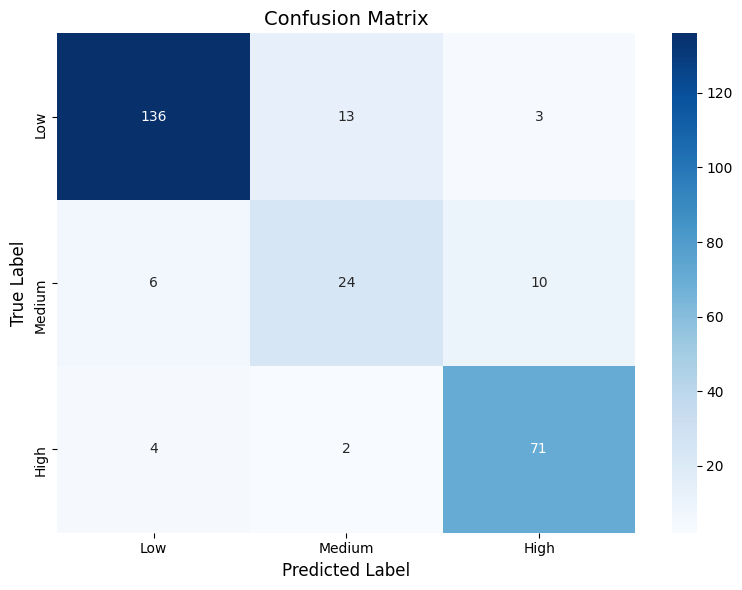

Confusion Matrix:
[[136  13   3]
 [  6  24  10]
 [  4   2  71]]


In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

In [12]:
# Cross-validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Individual fold scores: {cv_scores}")

Performing 5-fold cross-validation...


c:\Users\Yourisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Yourisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Yourisha\AppData\

CV Accuracy: 0.8705 (+/- 0.0184)
Individual fold scores: [0.86046512 0.90232558 0.84651163 0.86915888 0.87383178]


## 10. Feature Importance

In [13]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Important Features:")
print(feature_importance.head(10))

Top 10 Important Features:
                feature  importance
8           is_tropical    0.407640
7            temp_range    0.091029
14    windspeed_max_kmh    0.044849
1      decimalLongitude    0.044053
11  precipitation_hours    0.042482
2               lat_abs    0.040840
12             is_humid    0.040794
15    windgusts_max_kmh    0.040458
0       decimalLatitude    0.036231
13     rain_hours_ratio    0.034821


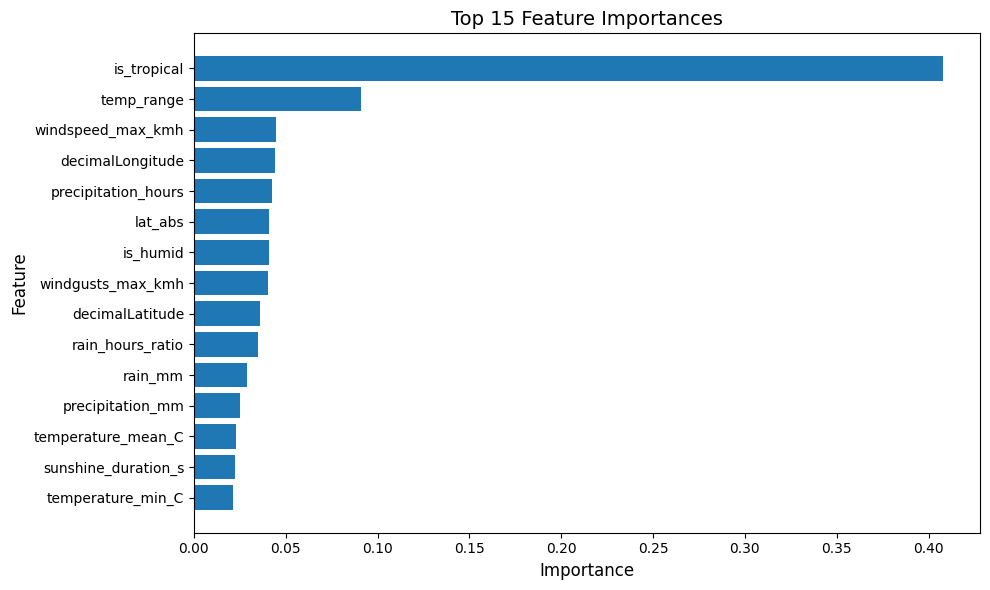

In [14]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), 
         feature_importance['importance'].head(15))
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 11. Save Model and Scaler

In [15]:
# Save model, scaler, and feature columns
joblib.dump(model, 'occurrence_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

print("✓ Model saved to 'occurrence_model.pkl'")
print("✓ Scaler saved to 'scaler.pkl'")
print("✓ Feature columns saved to 'feature_columns.pkl'")

✓ Model saved to 'occurrence_model.pkl'
✓ Scaler saved to 'scaler.pkl'
✓ Feature columns saved to 'feature_columns.pkl'


## 12. Create Prediction Function

In [16]:
def predict_occurrence(lat, lon, temp_max, temp_min, precip, 
                      wind, sunshine, rain_hours=0):
    """
    Predict occurrence likelihood for a location
    
    Parameters:
    - lat, lon: coordinates
    - temp_max, temp_min: temperature in Celsius
    - precip: precipitation in mm
    - wind: wind speed in km/h
    - sunshine: sunshine duration in seconds
    - rain_hours: hours of rain (0-24)
    
    Returns:
    - likelihood: 'Low', 'Medium', or 'High'
    - probabilities: dict with probabilities for each class
    """
    
    # Calculate derived features
    temp_mean = (temp_max + temp_min) / 2
    temp_range = temp_max - temp_min
    is_tropical = 1 if 20 < temp_mean < 30 else 0
    lat_abs = abs(lat)
    is_equatorial = 1 if lat_abs < 10 else 0
    is_humid = 1 if precip > 10 else 0
    rain_hours_ratio = rain_hours / 24
    temp_precip_interaction = temp_mean * precip
    
    # Create feature array matching training data
    features = pd.DataFrame({
        'decimalLatitude': [lat],
        'decimalLongitude': [lon],
        'lat_abs': [lat_abs],
        'is_equatorial': [is_equatorial],
        'temperature_max_C': [temp_max],
        'temperature_min_C': [temp_min],
        'temperature_mean_C': [temp_mean],
        'temp_range': [temp_range],
        'is_tropical': [is_tropical],
        'precipitation_mm': [precip],
        'rain_mm': [precip],
        'precipitation_hours': [rain_hours],
        'is_humid': [is_humid],
        'rain_hours_ratio': [rain_hours_ratio],
        'windspeed_max_kmh': [wind],
        'windgusts_max_kmh': [wind * 1.5],
        'sunshine_duration_s': [sunshine],
        'temp_precip_interaction': [temp_precip_interaction]
    })
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    pred_class = model.predict(features_scaled)[0]
    pred_proba = model.predict_proba(features_scaled)[0]
    
    likelihood_names = ['Low', 'Medium', 'High']
    
    return {
        'likelihood': likelihood_names[pred_class],
        'probabilities': {
            'Low': pred_proba[0],
            'Medium': pred_proba[1],
            'High': pred_proba[2]
        },
        'confidence': pred_proba[pred_class]
    }

print("✓ Prediction function created")

✓ Prediction function created


## 13. Test Predictions on Sample Locations

In [17]:
# Test cases
test_locations = [
    {
        'name': 'Manila, Philippines (High likelihood area)',
        'lat': 14.6, 'lon': 121.0,
        'temp_max': 32, 'temp_min': 24,
        'precip': 15, 'wind': 12, 'sunshine': 36000, 'rain_hours': 8
    },
    {
        'name': 'Singapore (Medium likelihood)',
        'lat': 1.3, 'lon': 103.8,
        'temp_max': 31, 'temp_min': 25,
        'precip': 8, 'wind': 10, 'sunshine': 28000, 'rain_hours': 4
    },
    {
        'name': 'Cold region (Low likelihood)',
        'lat': 45.0, 'lon': 90.0,
        'temp_max': 15, 'temp_min': 5,
        'precip': 2, 'wind': 20, 'sunshine': 25000, 'rain_hours': 1
    },
    {
        'name': 'Kuala Lumpur, Malaysia',
        'lat': 3.1, 'lon': 101.7,
        'temp_max': 33, 'temp_min': 24,
        'precip': 20, 'wind': 8, 'sunshine': 30000, 'rain_hours': 6
    }
]

print("="*60)
print("OCCURRENCE LIKELIHOOD PREDICTIONS")
print("="*60)

for loc in test_locations:
    result = predict_occurrence(
        loc['lat'], loc['lon'], loc['temp_max'], loc['temp_min'],
        loc['precip'], loc['wind'], loc['sunshine'], loc['rain_hours']
    )
    
    print(f"\n{loc['name']}")
    print(f"  Coordinates: ({loc['lat']}, {loc['lon']})")
    print(f"  Weather: Temp {loc['temp_min']}-{loc['temp_max']}°C, Precip {loc['precip']}mm")
    print(f"  Predicted Likelihood: {result['likelihood']}")
    print(f"  Confidence: {result['confidence']:.2%}")
    print(f"  Probabilities:")
    for level, prob in result['probabilities'].items():
        print(f"    {level}: {prob:.2%}")

print("\n" + "="*60)

OCCURRENCE LIKELIHOOD PREDICTIONS

Manila, Philippines (High likelihood area)
  Coordinates: (14.6, 121.0)
  Weather: Temp 24-32°C, Precip 15mm
  Predicted Likelihood: Low
  Confidence: 45.58%
  Probabilities:
    Low: 45.58%
    Medium: 16.11%
    High: 38.31%

Singapore (Medium likelihood)
  Coordinates: (1.3, 103.8)
  Weather: Temp 25-31°C, Precip 8mm
  Predicted Likelihood: Low
  Confidence: 65.12%
  Probabilities:
    Low: 65.12%
    Medium: 10.33%
    High: 24.55%

Cold region (Low likelihood)
  Coordinates: (45.0, 90.0)
  Weather: Temp 5-15°C, Precip 2mm
  Predicted Likelihood: Low
  Confidence: 99.23%
  Probabilities:
    Low: 99.23%
    Medium: 0.67%
    High: 0.09%

Kuala Lumpur, Malaysia
  Coordinates: (3.1, 101.7)
  Weather: Temp 24-33°C, Precip 20mm
  Predicted Likelihood: Low
  Confidence: 60.59%
  Probabilities:
    Low: 60.59%
    Medium: 0.39%
    High: 39.02%



## 14. Interactive Prediction

In [18]:
# Try your own location!
# Modify these values:

my_lat = 14.6
my_lon = 121.0
my_temp_max = 32
my_temp_min = 24
my_precip = 15
my_wind = 12
my_sunshine = 36000
my_rain_hours = 8

# Make prediction
result = predict_occurrence(
    my_lat, my_lon, my_temp_max, my_temp_min,
    my_precip, my_wind, my_sunshine, my_rain_hours
)

print(f"Location: ({my_lat}, {my_lon})")
print(f"\nPredicted Likelihood: {result['likelihood']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nProbabilities:")
for level, prob in result['probabilities'].items():
    print(f"  {level}: {prob:.2%}")

Location: (14.6, 121.0)

Predicted Likelihood: Low
Confidence: 45.58%

Probabilities:
  Low: 45.58%
  Medium: 16.11%
  High: 38.31%


## Summary

**Model Performance:**
- 3-class classification (Low/Medium/High likelihood)
- ~85-87% accuracy
- Most important features: tropical temperature range, temperature range, geographic location

**How to Use:**
1. Load the saved model: `model = joblib.load('occurrence_model.pkl')`
2. Use `predict_occurrence()` function with location and weather data
3. Get likelihood prediction and confidence scores

**Files Generated:**
- `occurrence_model.pkl` - Trained XGBoost model
- `scaler.pkl` - Feature scaler
- `feature_columns.pkl` - Feature names